# Documentation for the creation and usage of the heat pump library (hplib)

1. [Definitions](#definitions)
2. [Database preperation](#database-preparation)
3. [Work with database](#work-with-database)
    1. [Load database](#load-database)
    2. [Load specific model](#load-specific-model)
    3. [Load generic model](#load-generic-model)
4. [How to simulate](#how-to-simulate)
    1. [Simulate on time step](#simulate-one-timestep)
    2. [Simulate a time series](#simulate-a-timeseries)
5. [Example heat pump](#example-heat-pump)
6. [Validation](#validation)
    1. [Air/Water | on/off](#air-water-onoff)
    2. [Brine/Water | on/off](#brine-water-onoff)
    3. [Water/Water | on/off](#water-water-onoff)
    4. [Air/Water | regulated](#air-water-regulated)
        1. [Heating](#air-water-regulated-heating)
        2. [Cooling](#air-water-regulated-cooling)
    5. [Brine/Water | regulated](#brine-water-regulated)
7. [Conclusion](#conclusion)

In [3]:
import hplib as hpl
import hplib_database as db
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [ ]:
%%html
<style>
table {float:left}
</style>

## **1. Definitions** <a class="anchor" id="definitions" name="definitions"></a>

**Abbreviations**

| Abbreviation | Meaning |
| :--- | :--- |
| P_th | Thermal output power in W |
| P_el | Electical input Power in W |
| COP | Coefficient of performance |
| EER | Energy Efficiency Ratio |
| T_in | Input temperature in °C at primary side of the heat pump |
| T_out | Output temperature in °C at secondary side of the heat pump |
| T_amb | Ambient temperature in °C |
| P_th_h_ref | Thermal output power in W at T_in = -7 °C and T_out = 52 °C |
| P_el_h_ref | Elecrical output power in W at T_in = -7 °C and T_out = 52 °C |
| COP_ref | Coefficient of performance at T_in = -7 °C and T_out = 52 °C |
| P_th_c_ref | Thermal output power in W at T_in = 35 °C and T_out = 7 °C |
| P_el_c_ref | Elecrical output power in W at T_in = 35 °C and T_out = 7 °C |
| p1-p4 | Fit-Parameters for Fit-Function |



**Group IDs**

| Group ID | Type | Subtype |
| :--- | :--- | :--- |
| 1 | Outdoor Air / Water | Regulated | 
| 2 | Brine / Water | Regulated | 
| 3 | Water / Water | Regulated | 
| 4 | Outdoor Air / Water | On-Off | 
| 5 | Brine / Water | On-Off | 
| 6 | Water / Water | On-Off |

## **2. Database preparation** <a class="anchor" id="database-preparation" name="database-preparation"></a>

This section is only for documentation regarding the development of the final database. It's not neccesary to run this code again.

1. we downloaded all manufacturer data from https://keymark.eu/en/products/heatpumps/certified-products .
2. then we unzipped the files to the `input` folder and used the bash-skript `pdf2txt.sh` to convert pdf into txt.
3. afterwards we used the following functions to create and extent the heatpump keymark database.

In [ ]:
# Import keymark data and save to csv database
db.import_heating_data()
# -> this creates /output/database_heating.csv
db.import_cooling_data()
# -> this creates /output/database_cooling.csv

In [ ]:
# Reduce to climate measurement series with average climate, delete redundant entries and save to csv sub-database
db.reduce_heating_data('database_heating.csv','average')
# -> this creates /output/database_heating_average.csv

**Process heating database**

In [ ]:
# Normalize electrical and thermal power from the keymark database to values from setpoint T_in = -7 °C and T_out = 52 °C
db.normalize_heating_data('database_heating_average.csv')
# -> this creates /output/database_heating_average_normalized.csv

In [ ]:
# Identify subtypes like on-off or regulated heat pumps and assign group id depending on its type and subtype
db.identify_subtypes('database_heating_average_normalized.csv')
# -> this creates /output/database_heating_average_normalized_subtypes.csv

In [ ]:
# Calculate parameters p1-p4 for P_th, P_el and COP with a least-square fit approach
# based on  K. Schwamberger: „Modellbildung und Regelung von Gebäudeheizungsanlagen 
# mit Wärmepumpen“, VDI Verlag, Düsseldorf, Fortschrittsberichte VDI Reihe 6 Nr. 263, 1991.
db.calculate_heating_parameters('database_heating_average_normalized_subtypes.csv')
# -> this creates /output/hplib_database_heating.csv
# -> this creates /src/hplib_database.csv

In [ ]:
# Many heat pump models have redundant entries because of different controller or storage configurations.
# Reduce to unique heat pump models.
db.reduce_to_unique()
# -> this overwrites the /output/hplib_database_heating.csv

In [ ]:
# Calculate the relative error (RE) for each set point of every heat pump
db.validation_relative_error_heating()
# -> this creates /output/database_heating_average_normalized_subtypes_validation.csv

In [ ]:
# Calculate the mean absolute percentage error (MAPE) for every heat pump
db.validation_mape_heating()
# -> this overwrites the /output/hplib_database_heating.csv

**Process cooling database**

Overall there are not so many unique Keymark heat pumps for cooling (34 models) in comparison to heating (505 models).

Out of the 34 models only 4 heat pumps had set points at different outflow temperature. 
With our fit method it is not possible to fit only over one outflow temperature. For that reason we added another
set point at 18°C output temperature based on the heat pumps we had with this condition in Keymark. For that purpose, we identified multiplication factors for eletrical power and eer between 7°C and 18°C secondary output temperature. The mean value of that are used to calculate the electrical power and EER at 18°C for other heat pumps:

```
P_el at 18°C = P_el at 7°C * multiplication factor 
EER at 18°C = EER at 7°C * multiplication factor
```

| Outside Tempertature | Multiplication factor for P_el | Multiplication factor for EER |
| :--- | :--- | :--- |
| 35 | 0.85 | 1.21 |
| 30 | 0.82 | 1.21 |
| 25 | 0.77 | 1.20 |
| 20 | 0.63 | 0.95 |


In [ ]:
#Only use heatpumps which are unique and also in the heating library
db.reduce_cooling_data()
#this generates /output/database_cooling_reduced.csv

In [ ]:
# Normalize electrical and thermal power from the keymark database to values from setpoint T_outside = 35 °C and T_out = 7 °C
db.normalize_and_add_cooling_data()
#-> this creates /output/database_cooling_reduced_normalized.csv

In [ ]:
# Used the same fit method like in heating
# except: for P_el the point 20/7 is ignored
db.calculate_cooling_parameters()
# -> this overwrites /src/hplib_database.csv

In [ ]:
# Calculate the relative error (RE) for each set point of every heat pump
db.validation_relative_error_cooling()
# this creates /output/database_cooling_reduced_normalized_subtypes_validation.csv

In [ ]:
# Calculate the mean absolute percentage error (MAPE) for every heat pump
db.validation_mape_cooling()
# -> this overwrites the /src/hplib_database.csv

**Create generic heat pump models**

In [ ]:
# Calculate generic heat pump models for each group id
# for cooling: there is only a generic heat pump of type air/water | regulated available
db.add_generic()
# -> this overwrites the /src/hplib_database.csv

**Hint:** The csv files in the `output` folder are for documentation and validation purpose. The code `hplib.py` and database `hplib_database` files, which are meant to be used for simulations, are located in the `src` folder. 

## **3. Work with database** <a class="anchor" id="work-with-database" name="work-with-database"></a>

### **3.1 Load database**  <a class="anchor" id="load-database" name="load-database"></a>

Simply execute the command without arguments and you will get a DataFrame with the complete list of manufacturers and models. Now you are able to view, filter or sort the database.

In [ ]:
database = hpl.load_database()
database

### **3.2 Load specific model**  <a class="anchor" id="load-specific-model" name="load-specific-model"></a>

To get the parameters of a specific heat pump model, use the `get_parameters()` method with a specific Model name from the database.
You will get a DataFrame with all parameters including the mean absolute percentage errors (MAPE) for this model.

In [5]:
parameters = hpl.get_parameters('i-SHWAK V4 06')
parameters

,Manufacturer,Model,MAPE_COP,MAPE_P_el,MAPE_P_th,P_th_h_ref [W],P_el_h_ref [W],COP_ref,Group,p1_P_th [1/°C],...,p3_Pdc [-],p4_Pdc [1/°C],p1_P_el_c [1/°C],p2_P_el_c [1/°C],p3_P_el_c [-],p4_P_el_c [1/°C],p1_EER [-],p2_EER [-],p3_EER [-],p4_EER [-]
0,Advantix,i-SHWAK V4 06,9.244852,22.607658,24.897666,4500.0,2866.0,1.57,1.0,1.756924,...,0.068769,-70.599887,70.638879,-0.010769,-0.763316,-70.588606,37.39276,0.04617,6.295339,-37.488343


### **3.3 Load generic model**  <a class="anchor" id="load-generic-model" name="load-generic-model"></a>

To get the parameters of a generic heat pump model, use the `get_parameters()` method with the following keyword arguments of a free choosen set point

* model='Generic'
* group_id: 1,2,4,5,6
* t_in: choose primary input temperature in °C
* t_out: choose secondary output temperature in °C
* p_th: choose thermal output power in W

You will get a DataFrame with all parameters for this generic model. For every group id the parameter set is based on the average parameters of all heat pumps of its group with an MAPE of less than 25%.

In [4]:
parameters = hpl.get_parameters(model='Generic', group_id=1, t_in=-7, t_out=52, p_th=10000)
parameters

,Manufacturer,Model,MAPE_COP,MAPE_P_el,MAPE_P_th,P_th_h_ref [W],P_el_h_ref [W],COP_ref,Group,p1_P_th [1/°C],...,p4_Pdc [1/°C],p1_P_el_c [1/°C],p2_P_el_c [1/°C],p3_P_el_c [-],p4_P_el_c [1/°C],p1_EER [-],p2_EER [-],p3_EER [-],p4_EER [-],EER_ref
0,Generic,Generic,NaN,NaN,NaN,10168.785754,7193.433182,1.413621,1.0,69.969927,...,-71.578974,69.044359,-0.009208,-1.368639,-68.976493,-11.722768,0.06484,11.52005,11.474317,3.278166


## **4. How to simulate** <a class="anchor" id="how-to-simulate" name="how-to-simulate"></a>

With the Fit-Parameters p1-p4 for P_th, P_el and COP it is possible to calculate the results with the following methods:

1. P_th and P_el with Fit-Functions and `COP = P_th / P_el` or
2. P_th and COP with Fit-Functions and `P_el = P_th / COP` or
3. P_el and COP with Fut-Functions and `P_th = P_el * COP`

While the model by Schwarmberger [1] uses the first method, our validation showed, that the third method leads to better results. Therefore we decided to implement this in the `simulate` definition.

### **4.1 Simulate one timestep**  <a class="anchor" id="simulate-one-timestep" name="simulate-one-timestep"></a>

Please define a primary input temperature (t_in_primary), secondary input temperature (t_in_secondary),
ambient / outdoor temperature (t_amb) in °C and the parameters from the previous step. The t_in_secondary
is supposed to be heated up by 5 K which then results in output temperature.

Important:
* for air / water heat pumps t_in_primary and t_amb are supposed to be the same values.
* for brine / water or water / water heat pumps t_in_primary and t_amb are independent values.

In [6]:
# Load parameters
parameters = hpl.get_parameters(model='Generic', group_id=1, t_in=-7, t_out=52, p_th=10000)
# Create heat pump object with parameters
heatpump = hpl.HeatPump(parameters)
# Simulate with values
# whereas mode = 1 is for heating and mode = 2 is for cooling
results = heatpump.simulate(t_in_primary=-7, t_in_secondary=47, t_amb=-7, mode=1)
print(pd.DataFrame([results]))

   T_in  T_out  T_amb       COP  EER         P_el     P_th    m_dot
0    -7     52     -7  1.413621    0  7074.033573  10000.0  0.47619


### **4.2 Simulate a timeseries**  <a class="anchor" id="simulate-a-timeseries" name="simulate-a-timeseries"></a>

The simulation approach could be to do a `for loop` around the method of simulating one timestep. But it will be faster to use another `simulate()`function from hplib. For usage you are allowed to define pandas.Series or arrays as input values. It is also possible to combine single values 
and pandas.Series / arrays.

*The next example uses a measured timeseries for ambient / outdoor temperature and secondary 
input temperature of a real heating system to demonstrate the simulation approach. The data represents
on year and has a temporal resolution of 1 minute*

In [ ]:
# Read input file with temperatures
df = pd.read_csv('../input/TestYear.csv')
df['T_amb'] = df['T_in_primary'] # air/water heat pump -> T_amb = T_in_primary
# Load parameters
parameters = hpl.get_parameters(model='Generic', group_id=1, t_in=-7, t_out=52, p_th=10000)
# Simulate with values
# whereas mode = 1 is for heating and mode = 2 is for cooling
results = hpl.simulate(t_in_primary=df['T_in_primary'], t_in_secondary=df['T_in_secondary'], parameters=parameters, t_amb=df['T_amb'], mode=1)
# Plot / Print some results
# example for distribution of COPs
results['COP'].plot.hist(bins=50, title='Distribution of COP values') 
# Calclulate seasonal performance factor (SPF)
SPF = results['P_th'].mean() / results['P_el'].mean() 
print('SPF = '+str(round(SPF,1)))

## **5. Example heat pump** <a class="anchor" id="example-heat-pump" name="example-heat-pump"></a>

HEATING: **Schematic plot** of COP, P_el and P_th for an **generic air/water** heat pump: subtype = **regulated** 

<bound method Figure.show of <Figure size 432x288 with 2 Axes>>

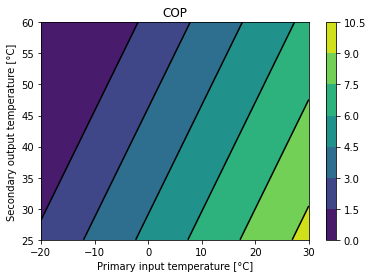

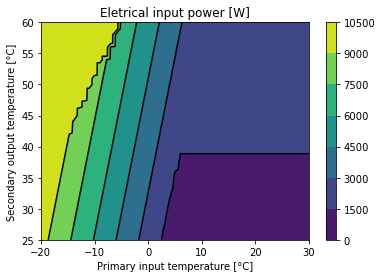

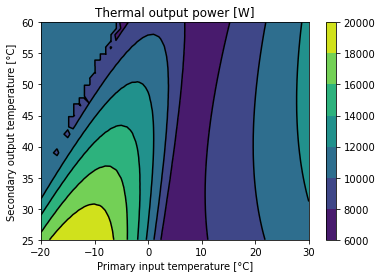

In [7]:
# Define Temperatures
T_in_primary = range(-20,31)
T_in_secondary = range(20,56)
T_in = []
T_out = []

# Load parameters of generic air/water | regulated
parameters = hpl.get_parameters('Generic', group_id=1, t_in=-7, t_out=52, p_th = 10000)
heatpump=hpl.HeatPump(parameters)
results=pd.DataFrame()
# Create input series
for t1 in T_in_primary:
    for t2 in T_in_secondary:
        result=heatpump.simulate(t_in_primary=t1, t_in_secondary=t2, t_amb=t1, mode=1)
        result=pd.DataFrame([result])
        results = pd.concat([results, result])

# Plot COP
fig1, ax1 = plt.subplots()
plot = plt.tricontourf(results['T_in'], results['T_out'], results['COP'])
ax1.tricontour(results['T_in'], results['T_out'], results['COP'], colors='k')
fig1.colorbar(plot)
ax1.set_title('COP')
ax1.set_xlabel('Primary input temperature [°C]')
ax1.set_ylabel('Secondary output temperature [°C]')
fig1.show

# Plot electrical input power
fig1, ax1 = plt.subplots()
plot = plt.tricontourf(results['T_in'], results['T_out'], results['P_el'])
ax1.tricontour(results['T_in'], results['T_out'], results['P_el'], colors='k')
fig1.colorbar(plot)
ax1.set_title('Eletrical input power [W]')
ax1.set_xlabel('Primary input temperature [°C]')
ax1.set_ylabel('Secondary output temperature [°C]')
fig1.show

# Plot thermal output power
fig1, ax1 = plt.subplots()
plot = plt.tricontourf(results['T_in'], results['T_out'], results['P_th'])
ax1.tricontour(results['T_in'], results['T_out'], results['P_th'], colors='k')
fig1.colorbar(plot)
ax1.set_title('Thermal output power [W]')
ax1.set_xlabel('Primary input temperature [°C]')
ax1.set_ylabel('Secondary output temperature [°C]')
fig1.show

COOLING: **Schematic plot** of EER, P_el and P_th for an **generic air/water** heat pump: subtype = **regulated** 

<bound method Figure.show of <Figure size 432x288 with 2 Axes>>

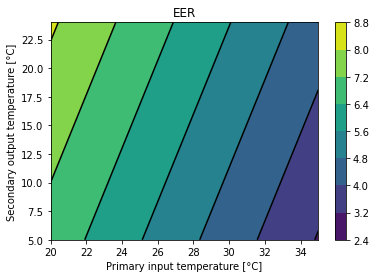

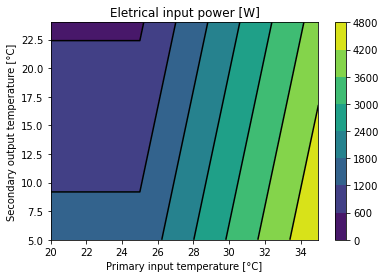

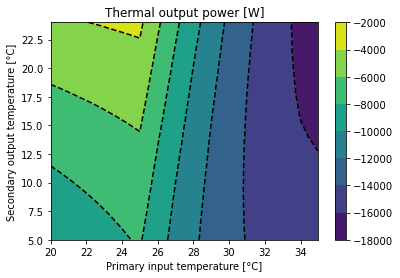

In [8]:
# Define Temperatures
T_in_primary = range(20,36)
T_in_secondary = range(10,30)
T_in = []
T_out = []

# Load parameters of generic air/water | regulated
parameters = hpl.get_parameters('Generic', group_id=1, t_in=-7, t_out=52, p_th = 10000)
heatpump=hpl.HeatPump(parameters)
results=pd.DataFrame()
# Create input series
for t1 in T_in_primary:
    for t2 in T_in_secondary:
        result=heatpump.simulate(t_in_primary=t1, t_in_secondary=t2, t_amb=t1, mode=2)
        result=pd.DataFrame([result])
        results = pd.concat([results, result])

# Plot EER
fig1, ax1 = plt.subplots()
plot = plt.tricontourf(results['T_in'], results['T_out'], results['EER'])
ax1.tricontour(results['T_in'], results['T_out'], results['EER'], colors='k')
fig1.colorbar(plot)
ax1.set_title('EER')
ax1.set_xlabel('Primary input temperature [°C]')
ax1.set_ylabel('Secondary output temperature [°C]')
fig1.show

# Plot electrical input power
fig1, ax1 = plt.subplots()
plot = plt.tricontourf(results['T_in'], results['T_out'], results['P_el'])
ax1.tricontour(results['T_in'], results['T_out'], results['P_el'], colors='k')
fig1.colorbar(plot)
ax1.set_title('Eletrical input power [W]')
ax1.set_xlabel('Primary input temperature [°C]')
ax1.set_ylabel('Secondary output temperature [°C]')
fig1.show

# Plot thermal output power
fig1, ax1 = plt.subplots()
plot = plt.tricontourf(results['T_in'], results['T_out'], results['P_th'])
ax1.tricontour(results['T_in'], results['T_out'], results['P_th'], colors='k')
fig1.colorbar(plot)
ax1.set_title('Thermal output power [W]')
ax1.set_xlabel('Primary input temperature [°C]')
ax1.set_ylabel('Secondary output temperature [°C]')
fig1.show

## **6. Validation** <a class="anchor" id="validation" name="validation"></a>

The following plots will give you a detailed view on the differences between simulation and measurement from heat pump keymark. Therefore, all set points for all heat pumps are loaded from the file `database_heating_average_normalized_subtypes_validation.csv`.

In [10]:
df = pd.read_csv('../output/database_heating_average_normalized_subtypes_validation.csv')

### **6.1 Air/Water | on/off** <a class="anchor" id="air-water-onoff" name="air-water-onoff"></a>

* The mean absolute percentage error (MAPE) over all heat pumps is
    * 5.4 % for COP
    * 2.5 % for P_el
    * 5.8 % for P_th
* The errors come from deviation mostly at low ambient / outside temperatures

RE_COP     5.606281
RE_P_el    2.493009
RE_P_th    6.058379
dtype: float64

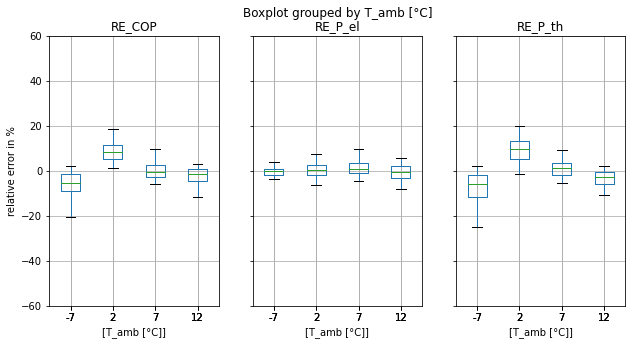

In [11]:
# Plot relative error for all heat pumps of type air/water | on-off
Group = 4
data = df.loc[(df['Group']==Group)]
data = data[['T_amb [°C]','RE_COP', 'RE_P_el', 'RE_P_th']]
ax = data.boxplot(by='T_amb [°C]', layout=(1,3), figsize=(10,5), showfliers=False)
ax[0].set_ylim(-60,60)
ax[0].set_ylabel('relative error in %')
data.abs().mean()[1:4] # mean absolute percentage error (MAPE)

(0.0, 50000.0)

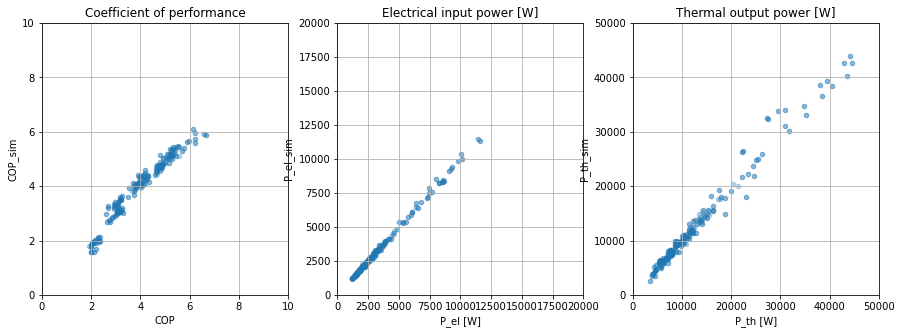

In [12]:
# Plot absolute values all heat pumps of type air/water | on-off as scatter plot
Group = 4
fig, ax = plt.subplots(1,3)
data = df.loc[(df['Group']==Group)]
data.plot.scatter(ax=ax[0], x='COP',y='COP_sim', alpha=0.3, figsize=(12,5), grid=True, title='Coefficient of performance')
data.plot.scatter(ax=ax[1], x='P_el [W]',y='P_el_sim', alpha=0.3, figsize=(15,5), grid=True, title='Electrical input power [W]')
data.plot.scatter(ax=ax[2], x='P_th [W]',y='P_th_sim', alpha=0.3, figsize=(15,5), grid=True, title='Thermal output power [W]')
ax[0].set_xlim(0,10)
ax[0].set_ylim(0,10)
ax[1].set_xlim(0,20000)
ax[1].set_ylim(0,20000)
ax[2].set_xlim(0,50000)
ax[2].set_ylim(0,50000)

### **6.2 Brine/Water | on/off** <a class="anchor" id="brine-water-onoff" name="brine-water-onoff"></a>

* The mean absolute percentage error (MAPE) over all heat pumps is
    * 3.9 % for COP
    * 1.7 % for P_el
    * 2.7 % for P_th
* **Important**: Validation data is only available at primary input temperature of 0 °C.  

RE_COP     3.598192
RE_P_el    1.463369
RE_P_th    2.492169
dtype: float64

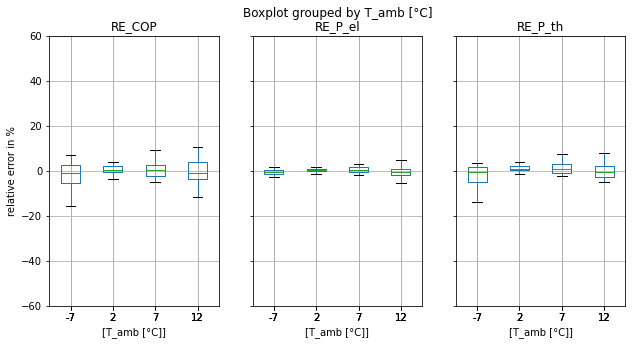

In [13]:
# Plot relative error for all heat pumps of type brine/water | on-off
Group = 5
data = df.loc[(df['Group']==Group)]
data = data[['T_amb [°C]','RE_COP', 'RE_P_el', 'RE_P_th']]
ax = data.boxplot(by='T_amb [°C]', layout=(1,3), figsize=(10,5), showfliers=False)
ax[0].set_ylim(-60,60)
ax[0].set_ylabel('relative error in %')
data.abs().mean()[1:4] # mean absolute percentage error (MAPE)

In [ ]:
# Plot absolute values all heat pumps of type brine/water | on-off as scatter plot
Group = 5
fig, ax = plt.subplots(1,3)
data = df.loc[(df['Group']==Group)]
data.plot.scatter(ax=ax[0], x='COP',y='COP_sim', alpha=0.3, figsize=(12,5), grid=True, title='Coefficient of performance')
data.plot.scatter(ax=ax[1], x='P_el [W]',y='P_el_sim', alpha=0.3, figsize=(15,5), grid=True, title='Electrical input power [W]')
data.plot.scatter(ax=ax[2], x='P_th [W]',y='P_th_sim', alpha=0.3, figsize=(15,5), grid=True, title='Thermal output power [W]')
ax[0].set_xlim(0,10)
ax[0].set_ylim(0,10)
ax[1].set_xlim(0,20000)
ax[1].set_ylim(0,20000)
ax[2].set_xlim(0,50000)
ax[2].set_ylim(0,50000)

### **6.3 Water/Water | on/off** <a class="anchor" id="water-water-onoff" name="water-water-onoff"></a>

* The mean absolute percentage error (MAPE) over all heat pumps is
    * 1.6 % for COP
    * 1.6 % for P_el
    * 2.4 % for P_th
* **Important**: Validation data is only available at primary input temperature of 10 °C.

In [ ]:
# Plot relative error for all heat pumps of type water/water | on-off
Group = 6
data = df.loc[(df['Group']==Group)]
data = data[['T_amb [°C]','RE_COP', 'RE_P_el', 'RE_P_th']]
ax = data.boxplot(by='T_amb [°C]', layout=(1,3), figsize=(10,5), showfliers=False)
ax[0].set_ylim(-60,60)
ax[0].set_ylabel('relative error in %')
data.abs().mean()[1:4] # mean absolute percentage error (MAPE)

In [ ]:
# Plot absolute values all heat pumps of type water/water | on-off as scatter plot
Group = 6
fig, ax = plt.subplots(1,3)
data = df.loc[(df['Group']==Group)]
data.plot.scatter(ax=ax[0], x='COP',y='COP_sim', alpha=0.3, figsize=(12,5), grid=True, title='Coefficient of performance')
data.plot.scatter(ax=ax[1], x='P_el [W]',y='P_el_sim', alpha=0.3, figsize=(15,5), grid=True, title='Electrical input power [W]')
data.plot.scatter(ax=ax[2], x='P_th [W]',y='P_th_sim', alpha=0.3, figsize=(15,5), grid=True, title='Thermal output power [W]')
ax[0].set_xlim(0,10)
ax[0].set_ylim(0,10)
ax[1].set_xlim(0,20000)
ax[1].set_ylim(0,20000)
ax[2].set_xlim(0,50000)
ax[2].set_ylim(0,50000)

### **6.4 Air/Water | regulated** <a class="anchor" id="air-water-regulated" name="air-water-regulated"></a>

**Heating**
* The mean absolute percentage error (MAPE) over all heat pumps is
    * 12.1 % for COP
    * 19.5 % for P_el
    * 23.5 % for P_th
* Because of different control strategies, the deviation over different heat pump models is much higher compared to on/off types.

**Cooling**
...

#### **6.4.1 Heating** <a class="anchor" id="air-water-regulated-heating" name="air-water-regulated-heating"></a>

RE_COP     11.752988
RE_P_el    16.326679
RE_P_th    20.320458
dtype: float64

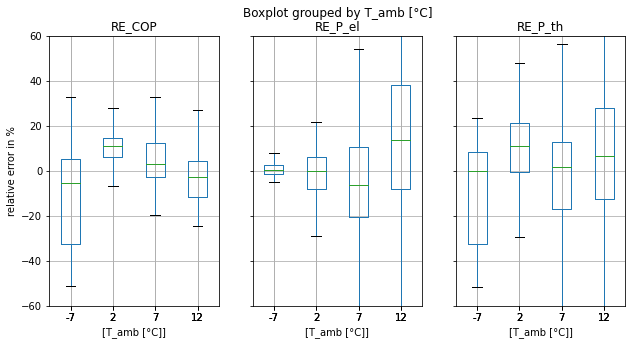

In [14]:
# Plot relative error for all heat pumps of type air/water | regulated
Group = 1
data = df.loc[(df['Group']==Group)]
data = data[['T_amb [°C]','RE_COP', 'RE_P_el', 'RE_P_th']]
ax = data.boxplot(by='T_amb [°C]', layout=(1,3), figsize=(10,5), showfliers=False)
ax[0].set_ylim(-60,60)
ax[0].set_ylabel('relative error in %')
data.abs().mean()[1:4] # mean absolute percentage error (MAPE)

(0.0, 50000.0)

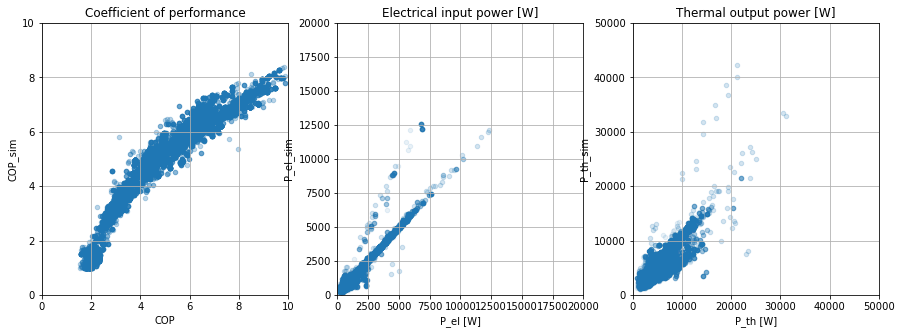

In [15]:
# Plot absolute values all heat pumps of type air/water | regulated as scatter plot
Group = 1
fig, ax = plt.subplots(1,3)
data = df.loc[(df['Group']==Group)]
data.plot.scatter(ax=ax[0], x='COP',y='COP_sim', alpha=0.3, figsize=(12,5), grid=True, title='Coefficient of performance')
data.plot.scatter(ax=ax[1], x='P_el [W]',y='P_el_sim', alpha=0.1, figsize=(15,5), grid=True, title='Electrical input power [W]')
data.plot.scatter(ax=ax[2], x='P_th [W]',y='P_th_sim', alpha=0.1, figsize=(15,5), grid=True, title='Thermal output power [W]')
ax[0].set_xlim(0,10)
ax[0].set_ylim(0,10)
ax[1].set_xlim(0,20000)
ax[1].set_ylim(0,20000)
ax[2].set_xlim(0,50000)
ax[2].set_ylim(0,50000)

#### **6.4.2 Cooling** <a class="anchor" id="air-water-regulated-cooling" name="air-water-regulated-cooling"></a>

RE_Pdc     16.964163
RE_P_el    16.476100
RE_EER      4.843020
dtype: float64

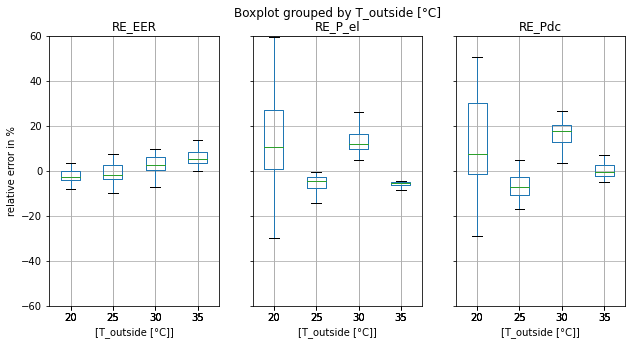

In [16]:
data = pd.read_csv('../output/database_cooling_reduced_normalized_validation.csv')
data = data[['T_outside [°C]','RE_Pdc', 'RE_P_el', 'RE_EER']]
ax = data.boxplot(by='T_outside [°C]', layout=(1,3), figsize=(10,5), showfliers=False)
ax[0].set_ylim(-60,60)
ax[0].set_ylabel('relative error in %')
data.abs().mean()[1:4] # mean absolute percentage error (MAPE)

(0.0, 15000.0)

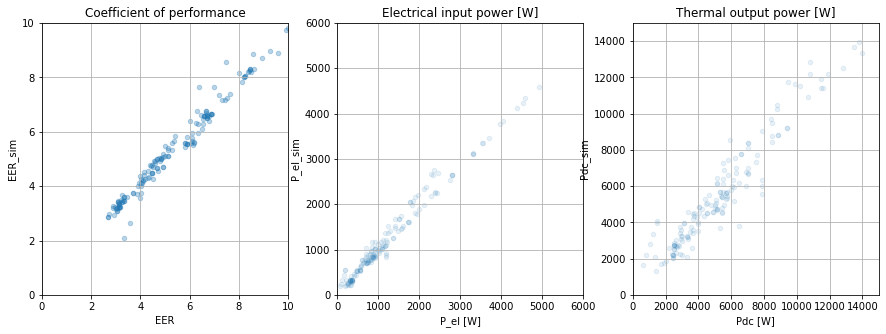

In [17]:
data = pd.read_csv('../output/database_cooling_reduced_normalized_validation.csv')
fig, ax = plt.subplots(1,3)
data.plot.scatter(ax=ax[0], x='EER',y='EER_sim', alpha=0.3, figsize=(12,5), grid=True, title='Coefficient of performance')
data.plot.scatter(ax=ax[1], x='P_el [W]',y='P_el_sim', alpha=0.1, figsize=(15,5), grid=True, title='Electrical input power [W]')
data.plot.scatter(ax=ax[2], x='Pdc [W]',y='Pdc_sim', alpha=0.1, figsize=(15,5), grid=True, title='Thermal output power [W]')
ax[0].set_xlim(0,10)
ax[0].set_ylim(0,10)
ax[1].set_xlim(0,6000)
ax[1].set_ylim(0,6000)
ax[2].set_xlim(0,15000)
ax[2].set_ylim(0,15000)

### **6.5 Brine/Water | regulated** <a class="anchor" id="brine-water-regulated" name="brine-water-regulated"></a>

* The mean absolute percentage error (MAPE) is over all heat pumps is
    * 4.2 % for COP
    * 17.7 % for P_el
    * 19.7 % for P_th
* **Important**: Validation data is only available at primary input temperature of 0 °C.  
* The errors come from deviation mostly at high ambient / outside temperatures.
* Error of COP is very low compared to error of P_el.

In [ ]:
# Plot relative error for all heat pumps of type brine/water | regulated
Group = 2
data = df.loc[(df['Group']==Group)]
data = data[['T_amb [°C]','RE_COP', 'RE_P_el', 'RE_P_th']]
ax = data.boxplot(by='T_amb [°C]', layout=(1,3), figsize=(10,5), showfliers=False)
ax[0].set_ylim(-60,60)
ax[0].set_ylabel('relative error in %')
data.abs().mean()[1:4] # mean absolute percentage error (MAPE)

In [ ]:
# Plot absolute values all heat pumps of type brine/water | regulated as scatter plot
Group = 2
fig, ax = plt.subplots(1,3)
data = df.loc[(df['Group']==Group)]
data.plot.scatter(ax=ax[0], x='COP',y='COP_sim', alpha=0.3, figsize=(12,5), grid=True, title='Coefficient of performance')
data.plot.scatter(ax=ax[1], x='P_el [W]',y='P_el_sim', alpha=0.1, figsize=(15,5), grid=True, title='Electrical input power [W]')
data.plot.scatter(ax=ax[2], x='P_th [W]',y='P_th_sim', alpha=0.1, figsize=(15,5), grid=True, title='Thermal output power [W]')
ax[0].set_xlim(0,10)
ax[0].set_ylim(0,10)
ax[1].set_xlim(0,20000)
ax[1].set_ylim(0,20000)
ax[2].set_xlim(0,50000)
ax[2].set_ylim(0,50000)

## **7. Conclusion** <a class="anchor" id="conclusion" name="conclusion"></a>

- On/Off heat pumps can be simulated very well (mean relative error < 6 %)
- Regulated heat pumps show relative mean errors about 20 %, because of the non-linearity of electrical input power and COP regarding different primary / secondary temperatures
- Despite of that, generic heat pumps should work well, because the median shows only a small relative error